## Random Forest

In [1]:
import pandas as pd

In [34]:
sp = pd.read_csv('S&P500-2025-01-10.csv', index_col='Date')
sp = sp.loc["1990-01-01":].copy()   # only keep data from 1990 onwards

Es mejor usar el .copy para evitar errores

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=8) 
    # n_estimators = number of trees in the forest
    # min_samples_split = minimum number of samples required to split an internal node, it protects against overfitting

No podemos usar cross-validation porque son series de tiempo.

In [37]:
train = sp.iloc[:-100] # Everything up to the last 100 rows 
test = sp.iloc[-100:]  # The last 100 rows

In [38]:
predictors = ["Open", "High", "Low", "Close", "Volume"]

In [39]:
model.fit(train[predictors], train["Target"])   # Train the model
# We are using the "Target" column as the target variable, which is the column we want to predict

RandomForestClassifier(min_samples_split=50, random_state=8)

## Evaluate the model

In [40]:
from sklearn.metrics import precision_score

In [41]:
preds = model.predict(test[predictors])     # Make predictions

In [42]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [43]:
preds = pd.Series(preds, index=test.index)  # Convert to a Series

In [44]:
preds

Date
2024-08-19 04:00:00+00:00    1
2024-08-20 04:00:00+00:00    1
2024-08-21 04:00:00+00:00    1
2024-08-22 04:00:00+00:00    1
2024-08-23 04:00:00+00:00    1
                            ..
2025-01-03 05:00:00+00:00    1
2025-01-06 05:00:00+00:00    0
2025-01-07 05:00:00+00:00    0
2025-01-08 05:00:00+00:00    0
2025-01-10 05:00:00+00:00    0
Length: 100, dtype: int64

In [54]:
test["Target"]

Date
2024-08-19 04:00:00+00:00    0
2024-08-20 04:00:00+00:00    1
2024-08-21 04:00:00+00:00    0
2024-08-22 04:00:00+00:00    1
2024-08-23 04:00:00+00:00    0
                            ..
2025-01-03 05:00:00+00:00    1
2025-01-06 05:00:00+00:00    0
2025-01-07 05:00:00+00:00    1
2025-01-08 05:00:00+00:00    0
2025-01-10 05:00:00+00:00    0
Name: Target, Length: 100, dtype: int64

In [45]:
precision_score(test["Target"], preds)      # Calculate precision

0.5396825396825397

C:\Users\herie\AppData\Local\Temp\ipykernel_35632\866227041.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wrong_indices = [i for i in range(len(preds)) if test["Target"][i] != preds[i]]
C:\Users\herie\AppData\Local\Temp\ipykernel_35632\866227041.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wrong_preds = [preds[i] for i in wrong_indices]


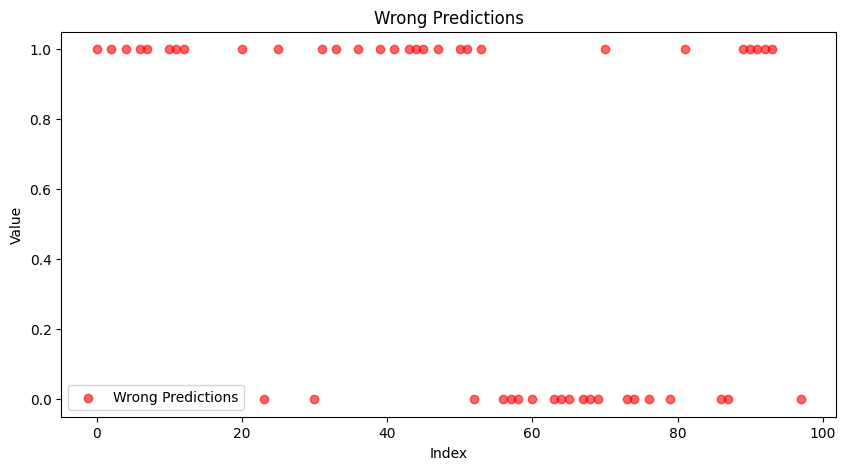

In [55]:
import matplotlib.pyplot as plt

# Assuming test["Target"] and preds are already defined
# Find the indices where predictions are wrong
wrong_indices = [i for i in range(len(preds)) if test["Target"][i] != preds[i]]

# Extract the values where predictions are wrong
wrong_preds = [preds[i] for i in wrong_indices]

plt.figure(figsize=(10, 5))

plt.scatter(wrong_indices, wrong_preds, label='Wrong Predictions', color='red', alpha=0.6)

# Adding title and labels
plt.title('Wrong Predictions')
plt.xlabel('Index')
plt.ylabel('Value')

# Adding legend
plt.legend()

# Show plot
plt.show()

## Lo vamso a mejorar con backtest

In [56]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [57]:
def backtest(data, model, predictors, start=2500, step=250):
    # start = index to start the backtest, take 10 years of data by default
    # step = number of rows to include in each test set, take 1 year by default

    all_predictions = [] # Store all predictions here for a single year

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [58]:
predictions = backtest(sp, model, predictors)

In [59]:
predictions["Predictions"].value_counts()

Predictions
0    3840
1    2483
Name: count, dtype: int64

In [60]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5320177204993959

In [61]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.535822
0    0.464178
Name: count, dtype: float64

## Adding additional predictors

In [62]:
horizons = [2, 5, 60, 250, 1000]    # means of the last 2 days, 5 days, ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # 2 days, 5 days, 60 days, 250 days, 1000 days
new_predictors = []                 # List to store the new predictors we will create

In [63]:
for horizon in horizons:
    rolling_averages = sp.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp[ratio_column] = sp["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp[trend_column] = sp.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [65]:
sp.tail()

,Open,High,Low,Close,Volume,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,
2025-01-03 05:00:00+00:00,5891.069824,5949.339844,5888.660156,5942.470215,3667340000,1,1.006259,1.0,1.004799,1.0,1.002820,33.0,1.091649,143.0,1.311840,527.0
2025-01-06 05:00:00+00:00,5982.810059,6021.040039,5960.009766,5975.379883,4940120000,0,1.002761,2.0,1.010209,2.0,1.007854,33.0,1.096718,143.0,1.318475,527.0
2025-01-07 05:00:00+00:00,5993.259766,6000.680176,5890.680176,5909.029785,4517330000,1,0.994417,1.0,0.998921,2.0,0.996302,33.0,1.083624,143.0,1.303227,527.0
2025-01-08 05:00:00+00:00,5910.660156,5927.890137,5874.779785,5918.250000,4441740000,0,1.000780,1.0,0.999243,3.0,0.997567,33.0,1.084412,143.0,1.304642,528.0
2025-01-10 05:00:00+00:00,5890.350098,5890.350098,5807.779785,5827.040039,4751930000,0,0.992234,1.0,0.985224,3.0,0.982284,32.0,1.066881,143.0,1.283961,527.0


In [66]:
sp500 = sp.dropna(subset=sp.columns[sp.columns != "Tomorrow"]) # Drop rows with NaN values, except for the "Tomorrow" column

## Improving the model

In [67]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=8)

In [68]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [69]:
predictions = backtest(sp500, model, new_predictors)

In [70]:
predictions["Predictions"].value_counts()

Predictions
0.0    4473
1.0     850
Name: count, dtype: int64

In [71]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5705882352941176

In [76]:
predictions.tail()

,Target,Predictions
Date,,
2025-01-03 05:00:00+00:00,1,1.0
2025-01-06 05:00:00+00:00,0,0.0
2025-01-07 05:00:00+00:00,1,0.0
2025-01-08 05:00:00+00:00,0,0.0
2025-01-10 05:00:00+00:00,0,0.0
